#### * Problem Definition

MNIST handwritten digit classification problem is a popular dataset used in deep learning community. Though the problem is effectively solved, it is still used as the basis for learning and practicing how to develop, evaluate, and use convolutional deep learning neural networks for image classification from scratch. This includes how to develop a robust mechanism estimating the performance of the model, how to explore improvements to the model, and how to save the model and later load it to make predictions on new data.


#### Choosing the right evaluation metrics

We prefer to choose ACCURACY as the evaluation metrics for this classification task. From data exploration tasks carried out, we infer that it is obvious that the data-set is a fairly balanced data-set (labels 0-9). No class imbalance.

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [69]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from collections.abc import Iterable
import time

In [70]:
def load_data():
    # load the train test MNIST Data
    (X_train,y_train),(X_test,y_test) = mnist.load_data()

    # Summarize the shape of loaded dataset
    print('Train : x = {}, y = {}'.format(X_train.shape,y_train.shape))
    print('Test : x = {}, y = {}'.format(X_test.shape,y_test.shape))
    return (X_train,y_train),(X_test,y_test)

Train : x = (60000, 28, 28), y = (60000,)
Test : x = (10000, 28, 28), y = (10000,)


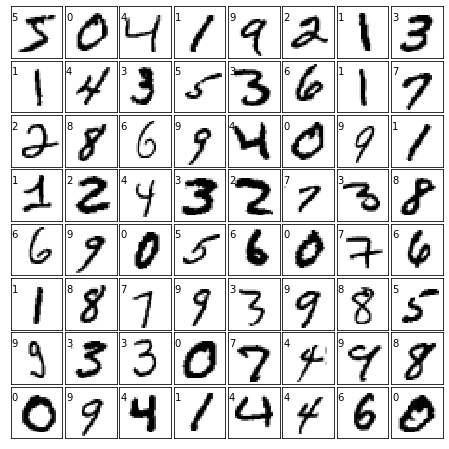

In [71]:
(X_train,y_train),(X_test,y_test) = load_data()

_,mat_rows,mat_cols = X_train.shape

#Figure size (widths, hight) in inches
fig = plt.figure(figsize=(6,6))

# Adjust the subplots 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

#For each of the 64 image
for i in range(64):
    ax = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
    #display i-th position image
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
    #label the image with target value
    ax.text(0,7,str(y_train[i]))

plt.show()    

## Exploratory Data Analysis

28 x 28 Gray Scale Images. 60,000 training and 10,000 images.

In order to train our neural network to classify images we first have to unroll the height \timeswidth pixel format into one big vector - the input vector. So its length must be 28 \cdot 28 = 784. But let's graph the distribution of our pixel values.


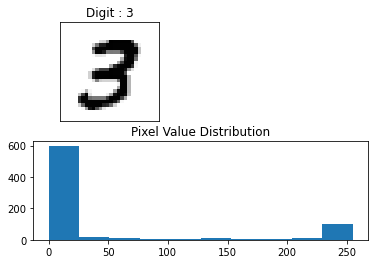

In [73]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(X_train[7]),cmap=plt.cm.binary, interpolation='nearest')
plt.title('Digit : {}'.format(y_train[7]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[7].reshape(784))
plt.title('Pixel Value Distribution')
plt.show()

* As expected, the pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.

In [74]:
#lable = np.unique(y_train)
label_List, labelCount = np.unique(y_train,return_counts=True)
print (label_List)
print (labelCount)

[0 1 2 3 4 5 6 7 8 9]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


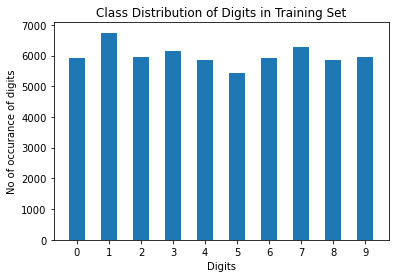

In [77]:
#plt.xticks(range(len(labelCount.tolist())),label_List)
plt.xticks(range(len(labelCount)),label_List)
plt.xlabel('Digits')
plt.ylabel('No of occurance of digits')
plt.title("Class Distribution of Digits in Training Set")
plt.bar(range(len(labelCount.tolist())),labelCount.tolist(),width=0.5)
plt.show()

In [5]:
# Flatten the images
img_vec_size = 28*28
X_train = X_train.reshape(X_train.shape[0],mat_rows, mat_cols)
X_test = X_test.reshape(X_test.shape[0],mat_rows, mat_cols)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
print("First 9 training labels as one-hot encoded vectors: \n", y_train[:9])

First 9 training labels as one-hot encoded vectors: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
def create_dense(layer_sizes,nodes,hidden_activation='sigmoid',output_activation='softmax',num_classes = 10,width=mat_rows, height=mat_cols, isDrop=False):
    model = Sequential()    
    
    model.add(Flatten(input_shape=(height, width)))
    ##model.add(Dense(layer_sizes[0], activation=hidden_activation, input_shape=(img_vec_size,)))
    
    if not isinstance(nodes, Iterable):
        nodes = [nodes] * (layer_sizes - 1)    
    
    for s in range(layer_sizes-1):
        if isDrop == True:
            model.add(Dropout(.5))
        model.add(Dense(units =nodes[s], activation=hidden_activation))

    #if isDrop == True:
     #   model.add(Dropout(.5))
    model.add(Dense(units=num_classes, activation=output_activation))
    print ('One hidden layer, {} nodes'.format(nodes))
    
    return model

def evaluate(model,optimizer='sgd', batch_size=128, epochs=5):
    #model.summary()

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=batch_size, validation_split = 0.1, epochs=epochs,verbose=False)

    loss, accuracy  = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=False)
    
    plt.plot(history.history['accuracy'])

    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')

    plt.ylabel('accuracy')

    plt.xlabel('epoch')

    plt.legend(['training', 'validation'], loc='best')

    plt.show()
   
    print('Test loss: {} with {} Optimizer'.format(round(loss,3),optimizer))

    print('Test accuracy: {} with {} Optimizer'.format(round(accuracy,3),optimizer))
    
    #Capture End Time
    print ('Execution time for the {} node is : {} Seconds'.format(nodes, round(time.time()-start_time,3)))
    print()    


## Task 1 - Execute a simple, fully-connected, neural network architecture with a single hidden layer with 32 nodes.

#### Hypothesis - Will get high accuracy with default hyperparameter?

*     **Description** : With lower value of the hyperparam, expecting faster execution with decent accuracy.
*     **Input :** passing no of epoch 5, batch size 128, 32 node layer with sgd (Stochastic gradient descent) optimizer     value.
*     **Output :** Execution time was 13.19 seconds with 81.6% of accuracy, Although execution time is less but accuracy is not upto the mark. 
*    **Conclusion:** I think, we can get better result with tuning of the parameter in next execution.  

One hidden layer, [32] nodes



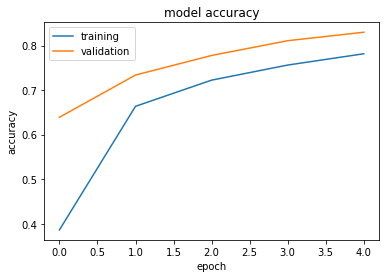

Test loss: 1.031 with sgd Optimizer
Test accuracy: 0.805 with sgd Optimizer
Execution time for the 32 node is : 43.183 Seconds



In [12]:

# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
model = create_dense(layer_sizes,nodes)
evaluate(model)


## Task 2 - ask 2 consists of 4 cases, where you are supposed to change the tunable parameters.

#### Case 1: Deep networks (e.g., different number of hidden layers while keeping nodes constant); use 32 nodes so results are comparable with Task 1 results.

#### Hypothesis - Get performance & accuracy measurement, with change of hyperparam ?

*     **Description** : With the change of hyperparameter in some permutation combination, evaluate the best   combination to get performance and accuracy.
*     **Input :** With the below combination of parameter, we do evaluate the performance.
        * Case 1 - Multiple layer size with fixed nodes
        * Case 2 - Increase the epoch value with fixed layer size and node.
        * Case 3 - Fixed layer with multiple node.
        * Case 4 - Multiple layer with muliple node
*     **Output :** Below is the output for above cases.
        * Case 1 - When we gradually increase layers, accuracy drastically getting down.
           * **Probable Reason -** Gradient optimization process might causing the issue, it could vanishing the gradient value.
        * Case 2 - When we increase epoch value, test accuracy is getting increase.
           * **Probable Reason -** This could be more process iteration on batch size. 
        * Case 3 - When we increase nodes, test accuracy is getting increasing.
        * Case 4 - Whenever layer size is getting increased, accuracy performance is getting worsen.
*    **Conclusion:** When we increase node & epoch value, accuracy is getting increase.  

One hidden layer, [32, 32] nodes


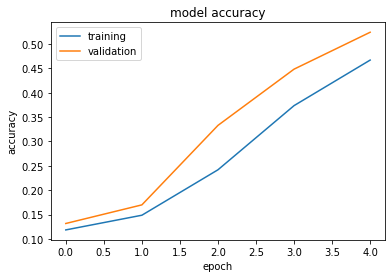

Test loss: 2.132 with sgd Optimizer
Test accuracy: 0.506 with sgd Optimizer
Execution time for the 32 node is : 15.105 Seconds

One hidden layer, [32, 32, 32, 32] nodes


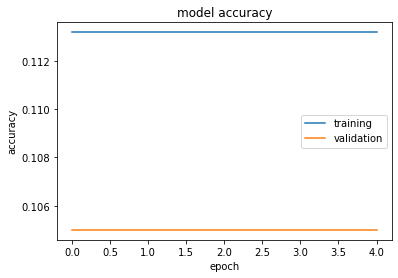

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the 32 node is : 35.381 Seconds

One hidden layer, [32, 32, 32, 32, 32, 32, 32, 32] nodes


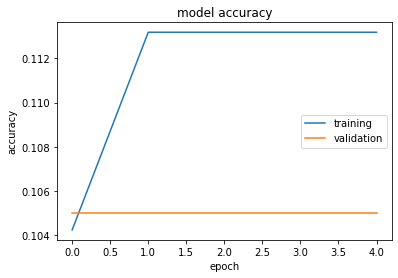

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the 32 node is : 61.055 Seconds

One hidden layer, [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32] nodes


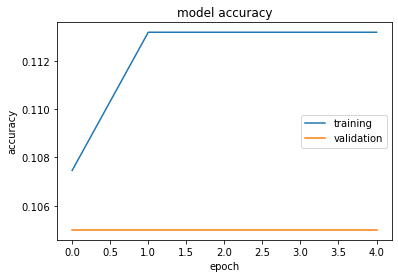

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the 32 node is : 97.815 Seconds



In [8]:

# Capture start time
start_time = time.time()
layer_sizes = [2,4,8,16]
nodes = 32
for layer in [2,4,8,16]:
    model = create_dense(layer+1,nodes)
    evaluate(model)

#### Case 1 - Conclusion :- While increasing the no of layers, model performace is geting worsen. 

#### Case 2: Train for longer

One hidden layer, [32] nodes


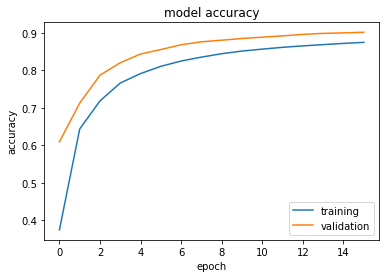

Test loss: 0.5 with sgd Optimizer
Test accuracy: 0.885 with sgd Optimizer
Execution time for the 32 node is : 32.679 Seconds



In [9]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
model = create_dense(layer_sizes,nodes)
evaluate(model,epochs=16)

One hidden layer, [32] nodes


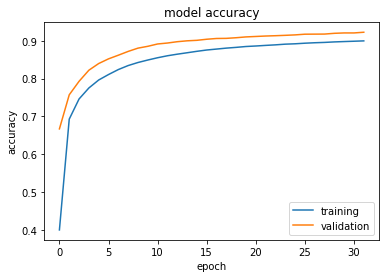

Test loss: 0.358 with sgd Optimizer
Test accuracy: 0.906 with sgd Optimizer
Execution time for the 32 node is : 67.73 Seconds



In [10]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
model = create_dense(layer_sizes,nodes)
evaluate(model,epochs=32)

#### Case 3: A single layer network (1 hidden layer) and increasing the number of nodes in the layer

One hidden layer, [64] nodes


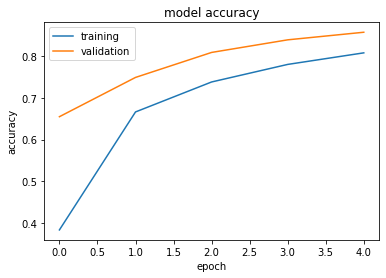

Test loss: 0.898 with sgd Optimizer
Test accuracy: 0.827 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 14.241 Seconds

One hidden layer, [128] nodes


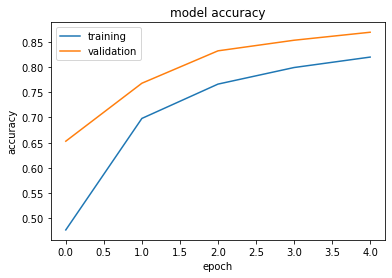

Test loss: 0.805 with sgd Optimizer
Test accuracy: 0.843 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 33.541 Seconds

One hidden layer, [256] nodes


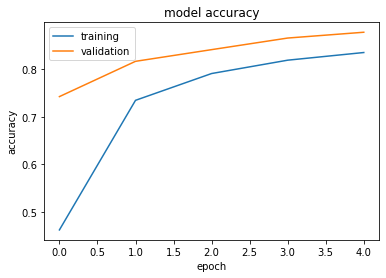

Test loss: 0.748 with sgd Optimizer
Test accuracy: 0.856 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 57.278 Seconds

One hidden layer, [512] nodes


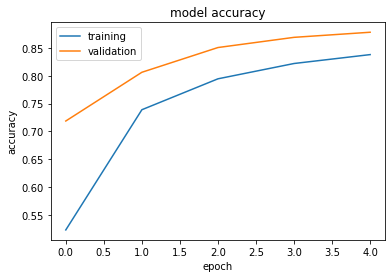

Test loss: 0.692 with sgd Optimizer
Test accuracy: 0.857 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 89.954 Seconds



In [11]:
start_time = time.time()
layer=2
nodes = [64, 128, 256, 512]
for node in nodes:
    model = create_dense(layer,node)
    evaluate(model)

#### Case 4: Adding more nodes and more layers

One hidden layer, [64] nodes


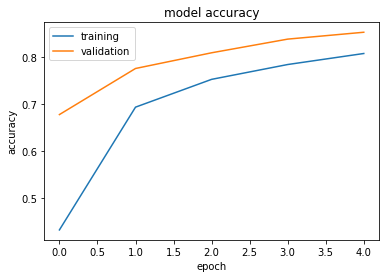

Test loss: 0.909 with sgd Optimizer
Test accuracy: 0.825 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 15.086 Seconds

One hidden layer, [64, 64, 64] nodes


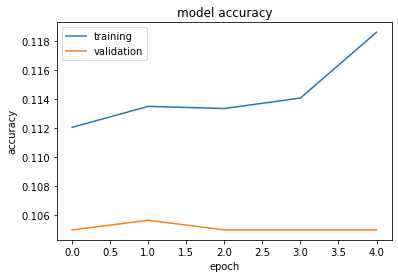

Test loss: 2.289 with sgd Optimizer
Test accuracy: 0.114 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 35.986 Seconds

One hidden layer, [64, 64, 64, 64, 64, 64, 64] nodes


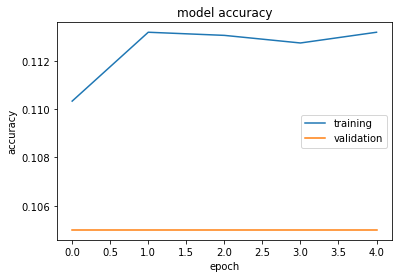

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 68.566 Seconds

One hidden layer, [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64] nodes


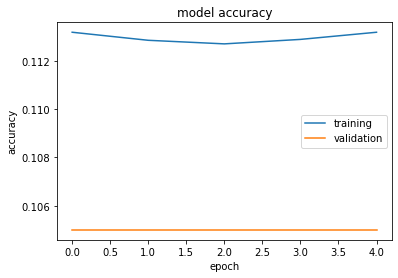

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 113.648 Seconds

One hidden layer, [128] nodes


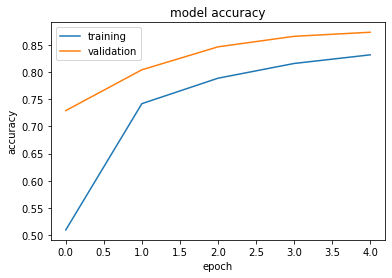

Test loss: 0.784 with sgd Optimizer
Test accuracy: 0.846 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 140.488 Seconds

One hidden layer, [128, 128, 128] nodes


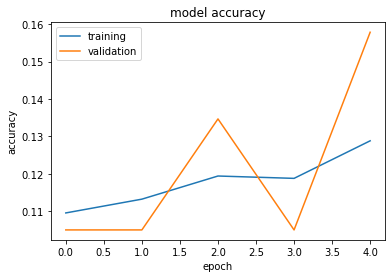

Test loss: 2.288 with sgd Optimizer
Test accuracy: 0.166 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 219.281 Seconds

One hidden layer, [128, 128, 128, 128, 128, 128, 128] nodes


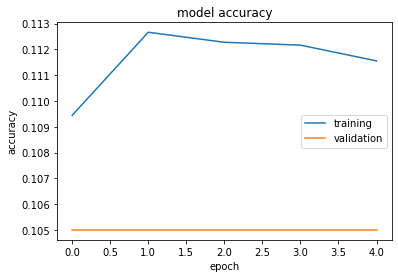

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 275.26 Seconds

One hidden layer, [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128] nodes


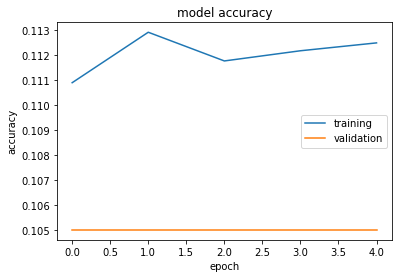

Test loss: 2.301 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 338.708 Seconds

One hidden layer, [256] nodes


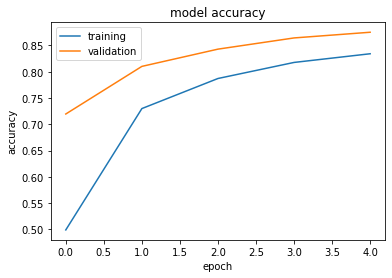

Test loss: 0.74 with sgd Optimizer
Test accuracy: 0.851 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 363.288 Seconds

One hidden layer, [256, 256, 256] nodes


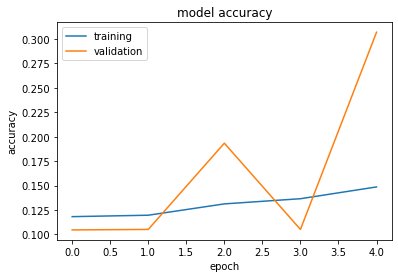

Test loss: 2.282 with sgd Optimizer
Test accuracy: 0.297 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 406.899 Seconds

One hidden layer, [256, 256, 256, 256, 256, 256, 256] nodes


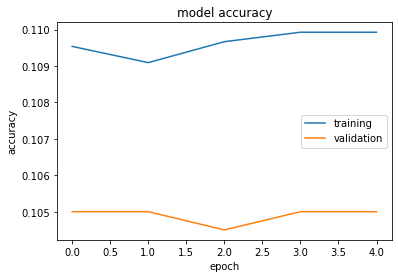

Test loss: 2.302 with sgd Optimizer
Test accuracy: 0.113 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 477.849 Seconds

One hidden layer, [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256] nodes


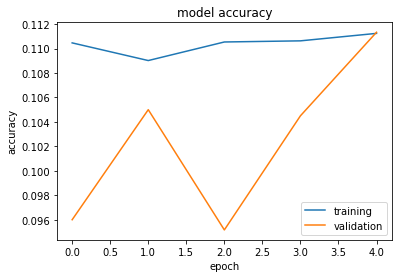

Test loss: 2.303 with sgd Optimizer
Test accuracy: 0.103 with sgd Optimizer
Execution time for the [64, 128, 256, 512] node is : 770.581 Seconds

One hidden layer, [512] nodes


In [ ]:
from itertools import product

start_time = time.time()
layers=[2,4,8,16]
nodes = [64, 128, 256, 512]

for n, l in product(nodes, layers):
    model = create_dense(l,n)
    evaluate(model)

#### Task 3: Get high accuracy after tunning on hyper-parameter. 

One hidden layer, [32] nodes


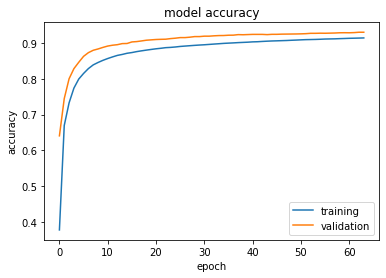

Test loss: 0.288 with sgd Optimizer
Test accuracy: 0.92 with sgd Optimizer
Execution time for the 32 node is : 502.064 Seconds



In [13]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
model = create_dense(layer_sizes,nodes)
evaluate(model,epochs=64)

#### After all above hypothesis testing, below combination of the hyperparameter has given best result.
*    ** Final Conclusion :** With Layer size 2, node 32 and epoch=64, test accuracy is 92.1% and execution time is 502.06 seconds 

## Task 4:- change any parameter/architecture to improve the quality metrics

#### Hypothesis 1 - Change on hidden activation value could improve accuracy from 92% to 94%?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** Change the activation value from 'sigmoid' to 'relu'
*    **Output :-** Change on activation value has given expected results, now accuracy has increased 95%

One hidden layer, [32] nodes


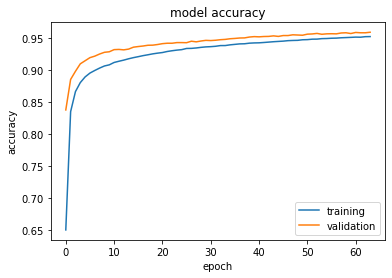

Test loss: 0.169 with sgd Optimizer
Test accuracy: 0.952 with sgd Optimizer
Execution time for the 32 node is : 74.626 Seconds



In [8]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
hidden_activation='relu'
model = create_dense(layer_sizes,nodes,hidden_activation)
evaluate(model,epochs=64)

#### Hypothesis 2 - multiple diffrent node value could improve accuracy from 95% to 96%?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** include multiple nodes
*    **Output :-** Including multiple nodes, decrease the performace from 95% to 94%

One hidden layer, [16, 32, 64] nodes


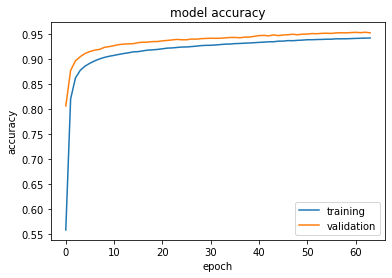

Test loss: 0.204 with sgd Optimizer
Test accuracy: 0.94 with sgd Optimizer
Execution time for the [16, 32, 64] node is : 79.999 Seconds



In [9]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = [16,32,64]
hidden_activation='relu'
model = create_dense(layer_sizes,nodes,hidden_activation)
evaluate(model,epochs=64)

#### Hypothesis 3 - Change on optimization value could improve accuracy from 95% to 96%?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** change the optimizer from 'sgd' to 'adam' with 'sigmoid' activation
*    **Output :-** change has improve the accuracy from 95% to 96% but overfitting observed based on the graph.

One hidden layer, [32] nodes


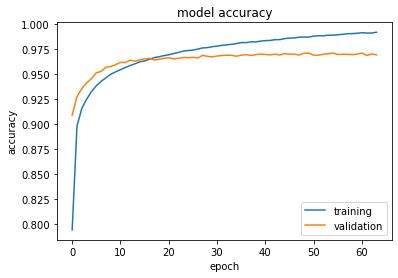

Test loss: 0.132 with adam Optimizer
Test accuracy: 0.964 with adam Optimizer
Execution time for the 32 node is : 86.811 Seconds



In [10]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
hidden_activation='sigmoid'
model = create_dense(layer_sizes,nodes,hidden_activation)
evaluate(model,optimizer='adam',epochs=64)

#### Hypothesis 5 - Change on activation & optimizer value could improve accuracy from 96% to 98%?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** Change activation form 'sigmoid' to 'relu' along with optimizer 'adam'
*    **Output :-** small accuracy improvment observed (96.6%) but overfitting observed.

One hidden layer, [32] nodes


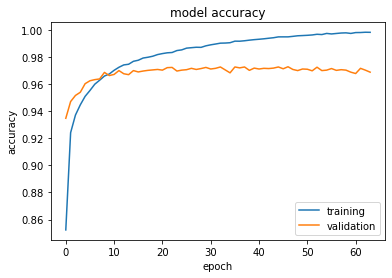

Test loss: 0.179 with adam Optimizer
Test accuracy: 0.966 with adam Optimizer
Execution time for the 32 node is : 84.346 Seconds



In [11]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = 32
hidden_activation='relu'
model = create_dense(layer_sizes,nodes,hidden_activation)
evaluate(model,optimizer='adam',epochs=64)

#### Hypothesis 7 - Change on batch size & epochs, could improve accuracy till 98%?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** Reduced the batch size from 128 to 64 and epoch value from 64 to 16.
*    **Output :-** Accuracy has almost reached the expected (97.7) but still observed overfitting on traning data.

One hidden layer, [128, 64, 32] nodes


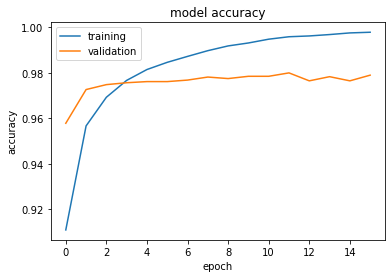

Test loss: 0.091 with adam Optimizer
Test accuracy: 0.977 with adam Optimizer
Execution time for the [128, 64, 32] node is : 53.195 Seconds



In [13]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = [128,64,32]
hidden_activation='relu'
model = create_dense(layer_sizes,nodes,hidden_activation)
evaluate(model,optimizer='adam',batch_size=64,epochs=16)

#### Hypothesis 7 - Due to overfitting, including the Dropout layer in model fitting process, it could eliminate overfitting without reducing accuracy (98%)?
*    **Description :-** We would change the other hyperparameter values like Activation, optimization, nodes, batch size and epoch value.
*    **Input :-** Introduce Droptout layer in model training.
*    **Output :-** Dropout layer has eliminate the overfitting issue on traning data without reducing the accuracy 98%.

One hidden layer, [128, 64, 32] nodes


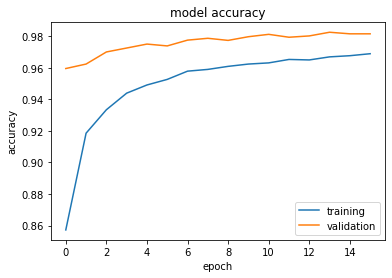

Test loss: 0.06 with adam Optimizer
Test accuracy: 0.98 with adam Optimizer
Execution time for the [128, 64, 32] node is : 66.739 Seconds



In [10]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = [128,64,32]
hidden_activation='relu'
model = create_dense(layer_sizes,nodes,hidden_activation,isDrop=True)
evaluate(model,optimizer='adam',batch_size=64,epochs=16)

## Task - 5

**FCNN**

* Initial model with below hyperparameter has given 80.5% accuracy with loss - 1.031 and it has taken 43.15 seconds.  
layer_sizes = 2
nodes = 32
activation = 'sigmoid'

* Best accuracy time for the task 1-3 is 92.1% with Layer size 2, node 32 and epoch=64, and execution time is 502.06 seconds

* We observe drastically reduced accuracy, when layer size increased > 2, this could be due to the gradient value vanished, when increase layer size.

* training Overfit issue occurs, when increase epoch value > 32 with optimizer 'adam' and this could be due to more iterations on training data but when we introduce dropout on model training, overfitting issue disappear. 

* After modification of the optimizer and activation value, accuracy increased more than 97%.

**CNN**
* CNN - Task 1 :- Test Acc - 89.89, Loss - .349, No of parameter - 251722
* CNN - Task 2 :- Test Acc - 94, Loss - 20.64% - Time - 1 Hour 15 Min
* CNN Task 2 - Case 1 (epoch - 5) - 2 Conv Layer 32 Futuer Max 5.5 Future Detector, 1 dense layer of 128 nodes - Train Param - 23,87,178, Test Accu - 73% Loss 100 %
* CNN Task 2 - Case 2 (epoch - 25) - 2 Conv Layer 32 Futuer Max 5.5 Future Detector, 1 dense layer of 128 nodes - Train Param - 23,87,178, Test Accu - 94% Loss 20 %, Training Time - 1 hr 15 Min

### Comparison:
1. Both the newtwork model has started with diffrence of accuracy (FCNN - 80.5%, CNN-89.89%) and execution time (FCNN - 43.13 Sec, CNN - ).
2. CNN has the advantage of weight sharing and reduced sparse connections. Better fitted for image processing.
3. With proper tuning (Layers, Max Pooling,Dropouts, Learning-Rates,Momentum,etc) was able to achieve higher accuracy with very less overfitting and in acceptable training time. Number of parameters were also in acceptable range.
4. Number of parameters in FCNN seem to be lower vis-a-vis proposed CNN model which had 2 Conv Layers with 32 feature maps and a large filter size of 5x5

## Extra Credits

### Introduce Noisy Labels

#### Hypothesis 1 - Introduce noise lables on target lables to examin, how model with behave with best fit param. Test accuracy should not reduce more than 3%
*    **Description** :- We introduced noise in target label, which should not reduce accuracy more than 3%
*    **Input :-** Introduce 11% of noise in target label.
*    **Output :-** Test Accuracy reduces 1% (98% to 97%) with excceded execution time from 66 sec to 142 sec but training accuracy has come down 85% from the 96%.


In [14]:
#Introduce Noise on target label.
def build_noisy_dataset(x_train, y_train, corruption_amount=0.11,
                        verbose=True,CLASSES=10):
    y_train = np.copy(y_train)  # to make sure we don't corrupt the orig
    shuffle_amount = int(corruption_amount * len(y_train))
    shuffle_start = np.random.randint(0, len(y_train) - shuffle_amount)
    shuffle_end = shuffle_start + shuffle_amount
    new_labels = np.random.randint(0, CLASSES, size=shuffle_amount)
    y_train[shuffle_start:shuffle_end] = to_categorical(
        new_labels, CLASSES
    )
    if verbose:
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x_train[shuffle_start + i],
                         cmap='gray', interpolation='bilinear')
            ax[i].set_title('Label: ' + str(np.argmax(
                y_train[shuffle_start + i]
            )))
    return y_train

Train : x = (60000, 28, 28), y = (60000,)
Test : x = (10000, 28, 28), y = (10000,)
First 9 training labels as one-hot encoded vectors: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


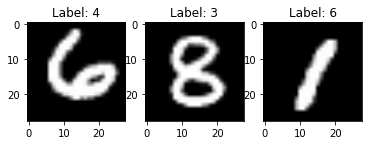

In [15]:
#Load fresh MNIST data
(X_train,y_train),(X_test,y_test) = load_data()

# Flatten the images
img_vec_size = 28*28
X_train = X_train.reshape(X_train.shape[0],mat_rows, mat_cols)
X_test = X_test.reshape(X_test.shape[0],mat_rows, mat_cols)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
print("First 9 training labels as one-hot encoded vectors: \n", y_train[:9])

# Introduce noise on dataset
y_train = build_noisy_dataset(X_train, y_train)

One hidden layer, [128, 64, 32] nodes


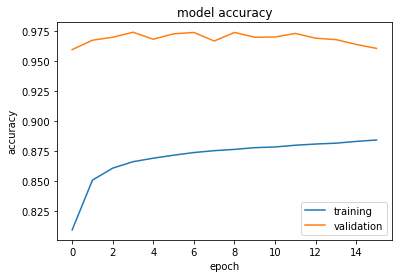

Test loss: 0.245 with adam Optimizer
Test accuracy: 0.961 with adam Optimizer
Execution time for the [128, 64, 32] node is : 100.554 Seconds



In [16]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = [128,64,32]
hidden_activation='relu'
#Call the best fit model param to train the Model
model = create_dense(layer_sizes,nodes,hidden_activation)

#Execute the model to get accuracy
evaluate(model,optimizer='adam',batch_size=64,epochs=16)

### obscured images

#### Hypothesis 1 - Introduce obscured image in test data set to test the model with best fit model param, but test accuracy should not reduce more than 3%.
*    **Description** :- obscured image could reduce the test accuracy but should not be more than 15%
*    **Input :-** Introduce noise as obscured images and use best fit model to train the model.
*    **Output :-** Test Accuracy reduces 1% (98% to 42.7%) with excceded execution time from 66 sec to 83.92 sec but training accuracy has come down 85% from the 96%.

In [17]:
def obscure_images(x, y, corruption_shape=(14, 14),
                   verbose=True):
    x = np.copy(x)  # to make sure we don't corrupt the orig
    mask = np.zeros(corruption_shape)
    for idx in range(x.shape[0]):
        i = np.random.randint(0, x.shape[1] - corruption_shape[0])
        j = np.random.randint(0, x.shape[2] - corruption_shape[1])
        x[idx, i:i+corruption_shape[0], j:j+corruption_shape[1]] = mask
    if verbose:
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x[i], cmap='gray', interpolation='bilinear')
            ax[i].set_title('Label: ' + str(np.argmax(
                y[i]
            )))
    return x

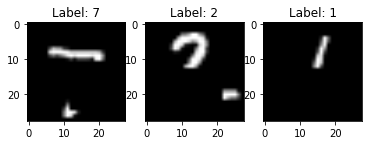

In [18]:
X_test = obscure_images(X_test, y_test)


One hidden layer, [128, 64, 32] nodes



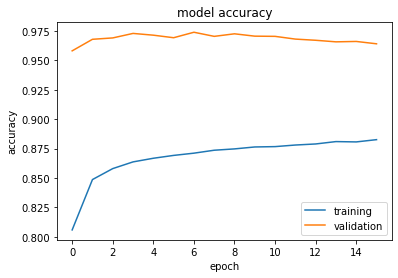

Test loss: 1.938 with adam Optimizer
Test accuracy: 0.427 with adam Optimizer
Execution time for the [128, 64, 32] node is : 181.807 Seconds



In [12]:
# Capture start time
start_time = time.time()
layer_sizes = 2
nodes = [128,64,32]
hidden_activation='relu'
#Call the best fit model param to train the Model
model = create_dense(layer_sizes,nodes,hidden_activation)

#Execute the model to get accuracy
evaluate(model,optimizer='adam',batch_size=64,epochs=16)